In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

import predictive_clustering,utils,predictive_plots,predictive_validation

## Testing Robustness of the Clusters


In [2]:
baseline = pd.read_excel("RETOS_BEBRASK_Baseline.xlsx")
scales = pd.read_excel("filled_scales_BEBRASK_RETOS.xlsx")
scaled_df = pd.read_excel("baseline_scaled.xlsx")
scaled_transformed_df = pd.read_excel("count_scaled_transformed.xlsx")


In [3]:
#Grouping the metrics that will be evaluated from scales for the BEBRASK and RETOS dataset (as the rest were no used
#or contain to many NaNs
PANAS = ["PA", "NA."]
ERQ = ["ERQ_CR", "ERQ_ES"]
UPPSP = ["UPPSP_NU", "UPPSP_PU", "UPPSP_SS", "UPPSP_PMD", "UPPSP_PSV"]
BIS_BAS = ["BIS", "BAS_D", "BAS_RR", "BAS_FS"]
TEPS = ["TEPS_AF", "TEPS_CF"]
SHS = ["SHS"]
FS = ["FS"]
LOTR = ["LOT_R"]
RRQ = ["RRQ_Rum", "RRQ_Ref"]
ASI3 = ["ASI_P", "ASI_C", "ASI_S"]
SPQ = ["SPQ", "SPQ_IR"]
MSSB = ["MSSB_POS", "MSSB_NEG", "MSSB_DES"]

list_metrics = [PANAS, ERQ, UPPSP, BIS_BAS, TEPS, SHS, FS, LOTR, RRQ, ASI3, SPQ, MSSB]
#### Importing the TimeSeries Dataset to use it for analysis later on

C:\Users\manue\anaconda3\envs\CASLabv2\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


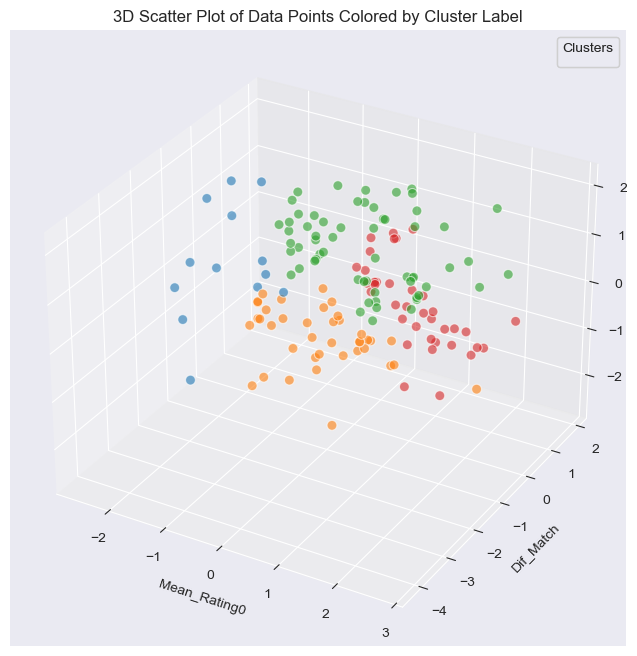

In [7]:
data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':4,'linkage':"complete"},fit=True)
df_cluster = pd.concat([scaled_df.copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Mean_Rating0","Dif_Match","Cor_Pred_Like","clusters"]

predictive_plots.plot_3d_clusters(df_cluster)

### LOOCV


In [8]:
data_clusters = predictive_clustering.clustering(scaled_df, AgglomerativeClustering,
                                                 {'n_clusters': 6, 'linkage': "complete"}, fit=True)
df_cluster = pd.concat([baseline["Subject"].copy(), pd.Series(data_clusters)], axis=1)
df_cluster.columns = ["Subject", "clusters"]
df_cluster

,Subject,clusters
0,PREDWELL_RETOS-1-1,1
1,PREDWELL_RETOS-10-1,2
2,PREDWELL_RETOS-1001-1,0
3,PREDWELL_RETOS-1002-1,0
4,PREDWELL_RETOS-1003-1,2
...,...,...
144,PREDWELL_RETOS-5-1,2
145,PREDWELL_RETOS-6-1,0
146,PREDWELL_RETOS-7-1,0
147,PREDWELL_RETOS-8-1,2


In [9]:
#We perform LOOCV, to check the stability of the clusters and also find the most critical subjects when forming clusters
results = []

# Iterate over each cluster
cluster_ind = [0,1,2,3,4]

predictive_clustering.analyze_cluster_stability(df_cluster = df_cluster,scaled_df = scaled_df, cluster_indices_list = cluster_ind, n_clusters = 6, output_list = results)


#For the outlier, we only create 5 clusters, as it would not make sense to create 6 clusters
cluster_ind = [5]

predictive_clustering.analyze_cluster_stability(df_cluster = df_cluster,scaled_df = scaled_df, cluster_indices_list = cluster_ind, n_clusters = 5, output_list = results)

results_df = pd.DataFrame(results)


In [10]:
# Find the two entries with the minimum 'Jaccard_Index' for each 'OriginalCluster'
most_impactful_two_indices = results_df.groupby('OriginalCluster').apply(
    lambda x: x.nsmallest(5, 'Jaccard_Index')
).reset_index(drop=True)

# Display the results
print(most_impactful_two_indices[['BelongingCluster','OriginalCluster', 'LeftOutSubjectIndex', 'Jaccard_Index']])


    BelongingCluster  OriginalCluster  LeftOutSubjectIndex  Jaccard_Index
0                  1                0                   28           0.30
1                  1                0                  109           0.31
2                  2                0                   35           0.31
3                  2                0                   81           0.31
4                  2                0                  129           0.31
5                  1                1                   29           0.47
6                  1                1                   75           0.47
7                  1                1                   61           0.65
8                  1                1                    6           0.72
9                  1                1                   88           0.72
10                 4                2                   90           0.66
11                 2                2                  137           0.70
12                 2                2 

In [11]:
# Group the results by 'OriginalCluster' and 'EvaluatedCluster', then calculate the mean 'Jaccard_Index' for each group
average_jaccard_indices = results_df.groupby(['OriginalCluster', 'BelongingCluster']).mean()['Jaccard_Index'].reset_index()

# Sort the results for better readability
average_jaccard_indices.sort_values(by=['OriginalCluster', 'BelongingCluster'], inplace=True)

# Display the results
print(average_jaccard_indices)

    OriginalCluster  BelongingCluster  Jaccard_Index
0                 0                 0       0.935667
1                 0                 1       0.900541
2                 0                 2       0.933158
3                 0                 3       0.674444
4                 0                 4       0.932500
5                 0                 5       1.000000
6                 1                 0       0.998333
7                 1                 1       0.917297
8                 1                 2       0.981053
9                 1                 3       1.000000
10                1                 4       1.000000
11                1                 5       1.000000
12                2                 0       0.989833
13                2                 1       0.988919
14                2                 2       0.952632
15                2                 3       0.915556
16                2                 4       0.915000
17                2                 5       1.

### Bootstrap Validation


In [12]:
data_clusters = predictive_clustering.clustering(scaled_df,AgglomerativeClustering,{'n_clusters':4,'linkage':"complete"},fit=True)
df_cluster = pd.concat([baseline["Subject"].copy(),pd.Series(data_clusters)],axis=1)
df_cluster.columns = ["Subject","clusters"]

original_means_df  = utils.scales_means_per_cluster(scales, df_cluster, list_metrics):


In [13]:
# Assuming 'scaled_df' and 'df_cluster' as before
n_samples = 1000  # Number of bootstrap samples
consistency_results = []
means_list = []
n_clusters = 4

# Original clusters for reference
original_clusters = [df_cluster[df_cluster['clusters'] == i].index for i in range(n_clusters)]

predictive_validation.bootstrap_validation(1000, 4, consistency_results, means_list, original_clusters, original_means_df
                         ,list_metrics,scaled_df,baseline,scales)



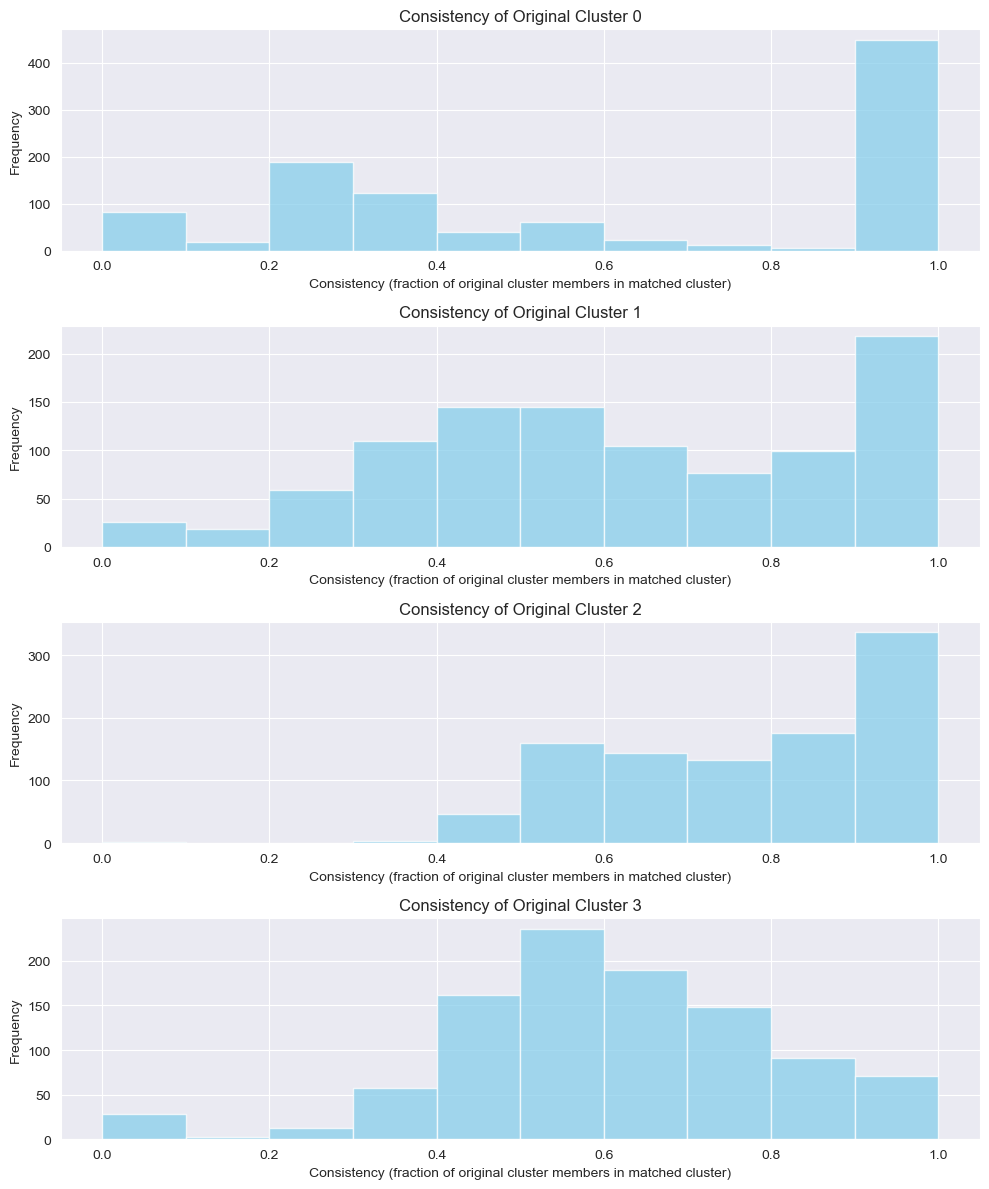

In [14]:
results_df = pd.DataFrame(consistency_results)

# Determine the number of unique clusters
unique_clusters = results_df['OriginalCluster'].unique()
n_clusters = len(unique_clusters)

# Create a figure with subplots - one for each cluster
fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 3 * n_clusters))  # Adjust the size as necessary

# Ensure axes is iterable (important when n_clusters == 1)
if n_clusters == 1:
    axes = [axes]

# Iterate over each cluster and plot its histogram
for i, ax in zip(unique_clusters, axes):
    # Extract consistency data for the current cluster
    cluster_consistency = results_df[results_df['OriginalCluster'] == i]['Consistency']

    # Plot histogram
    ax.hist(cluster_consistency, bins=10, alpha=0.75, color='skyblue')
    ax.set_title(f'Consistency of Original Cluster {i}')
    ax.set_xlabel('Consistency (fraction of original cluster members in matched cluster)')
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

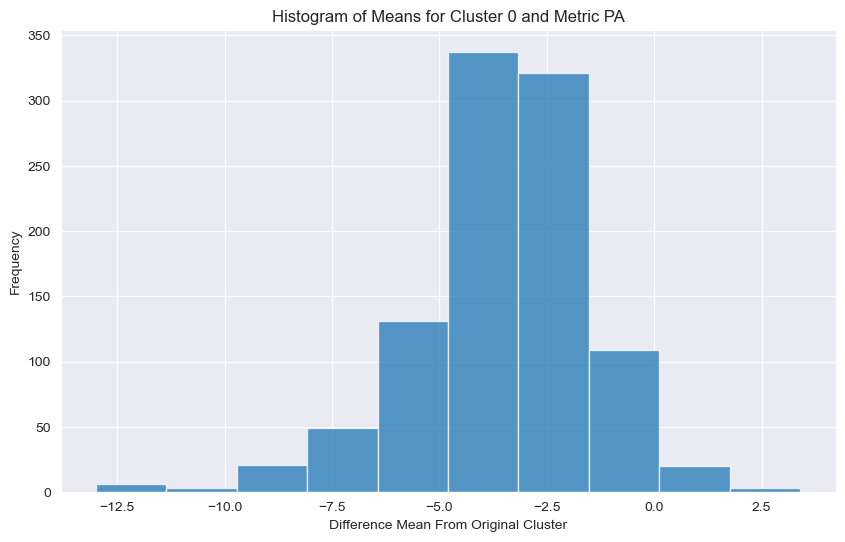

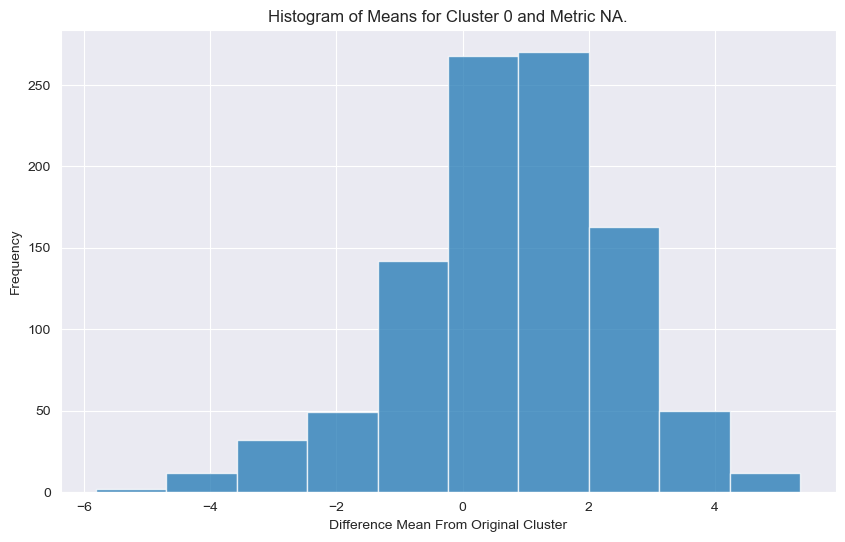

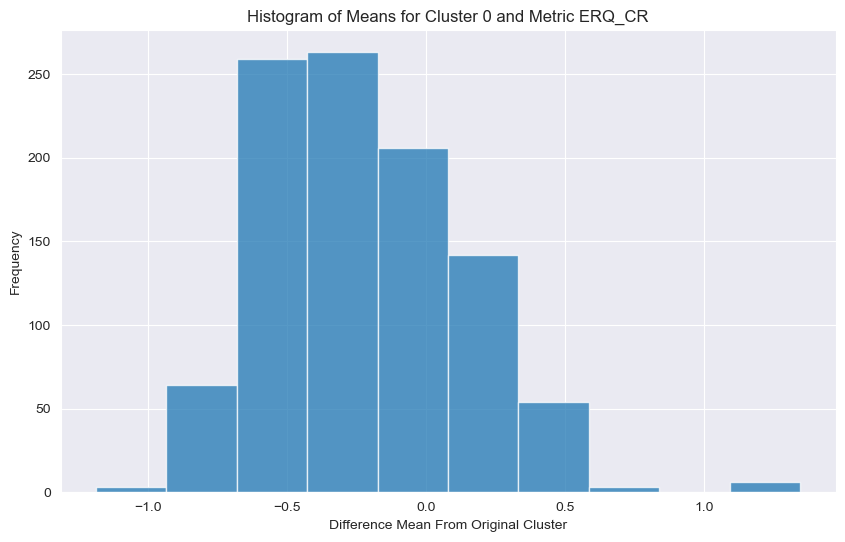

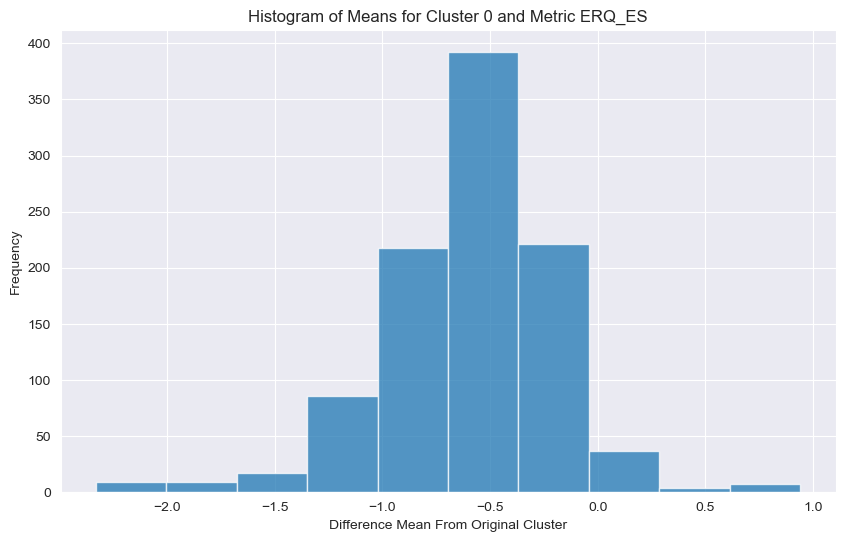

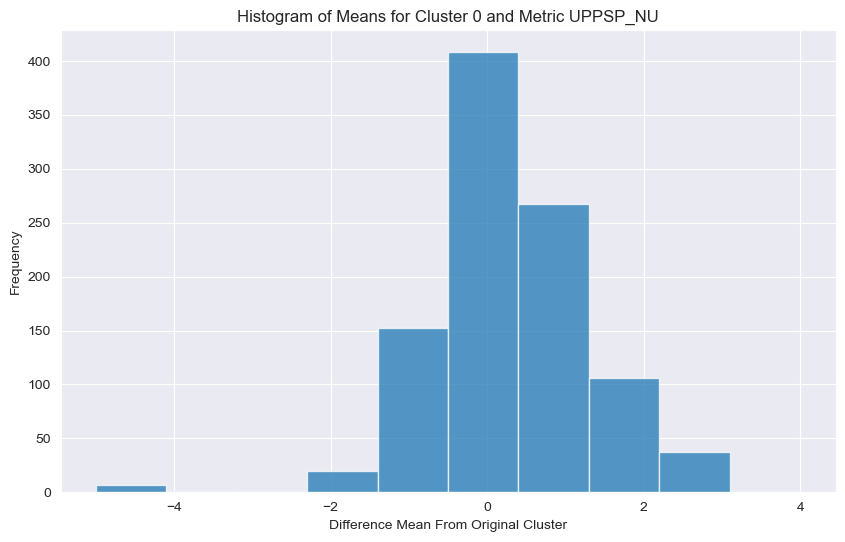

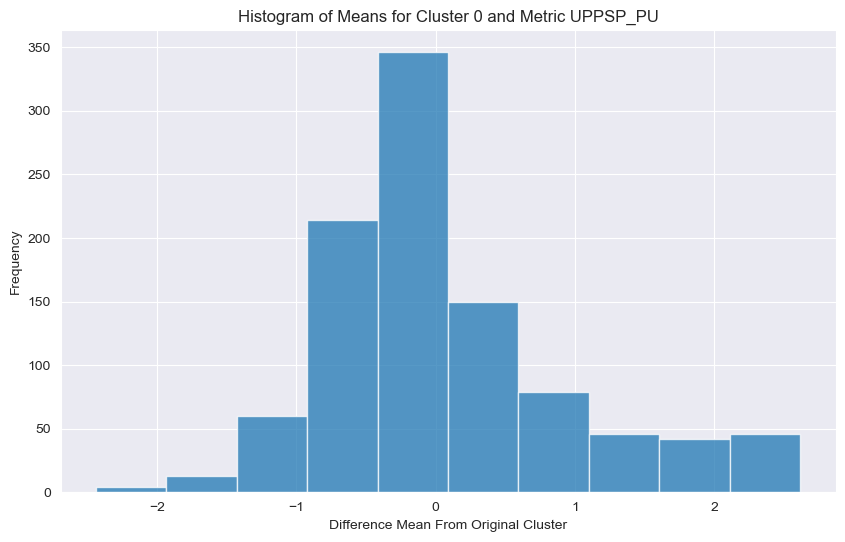

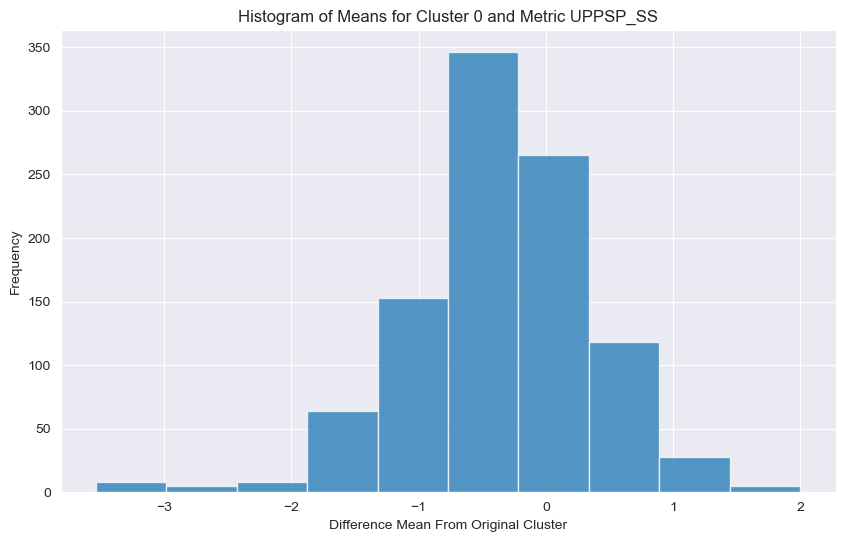

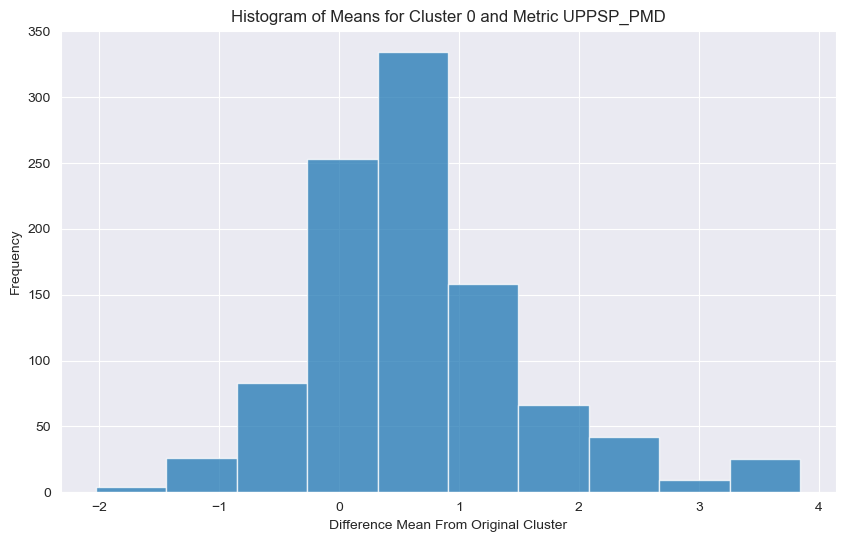

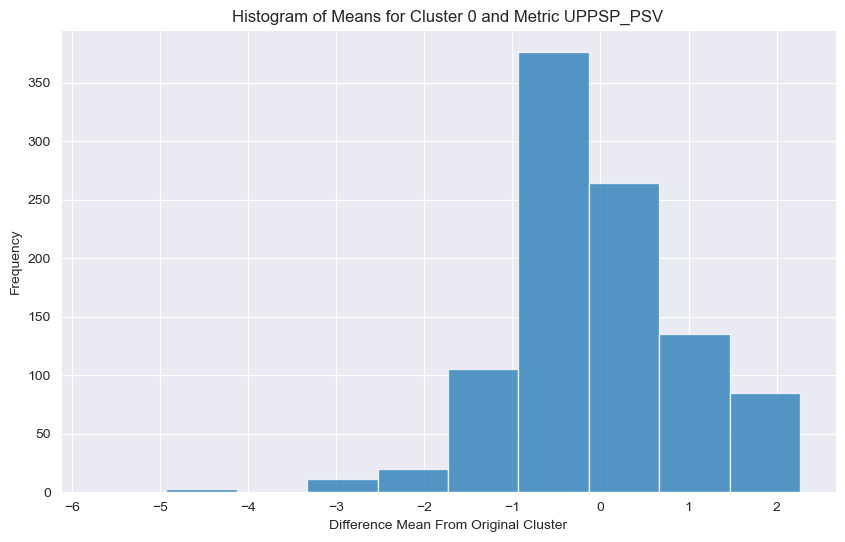

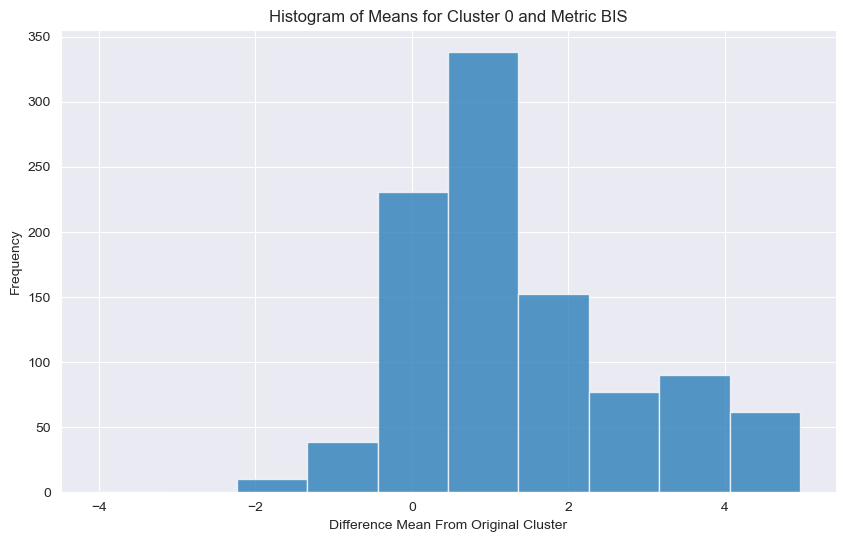

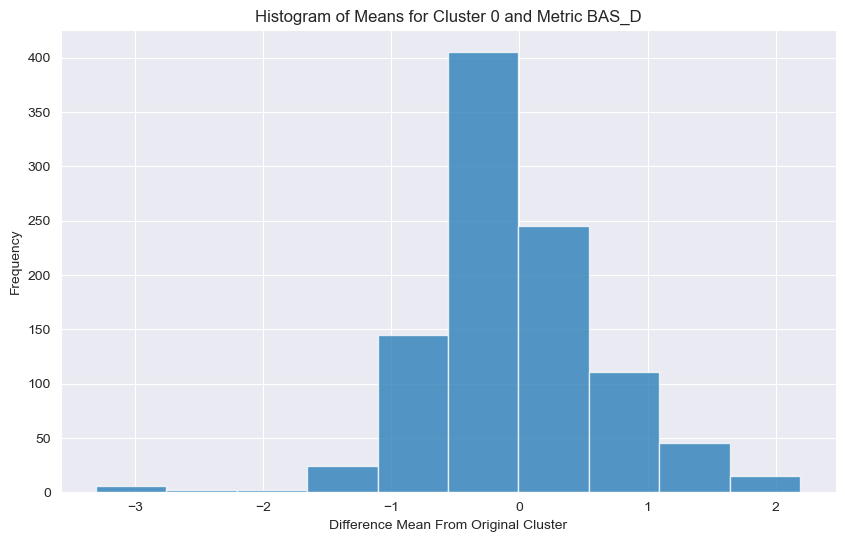

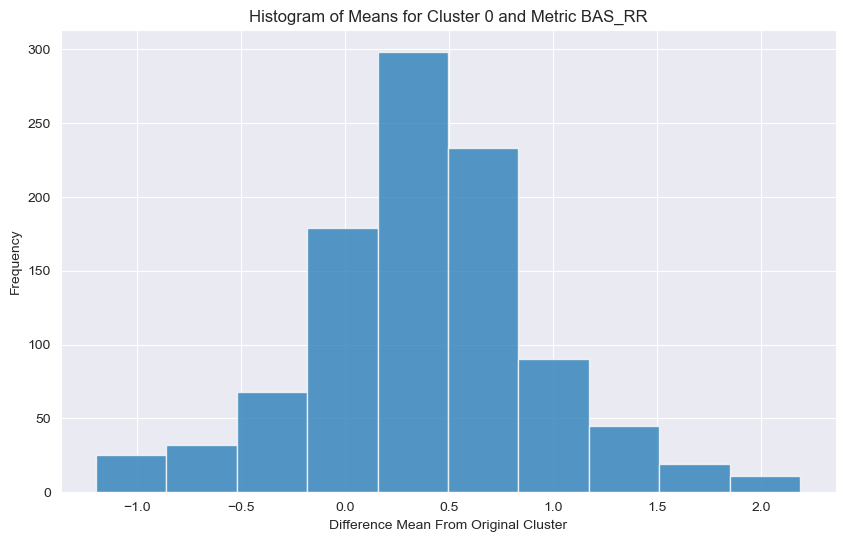

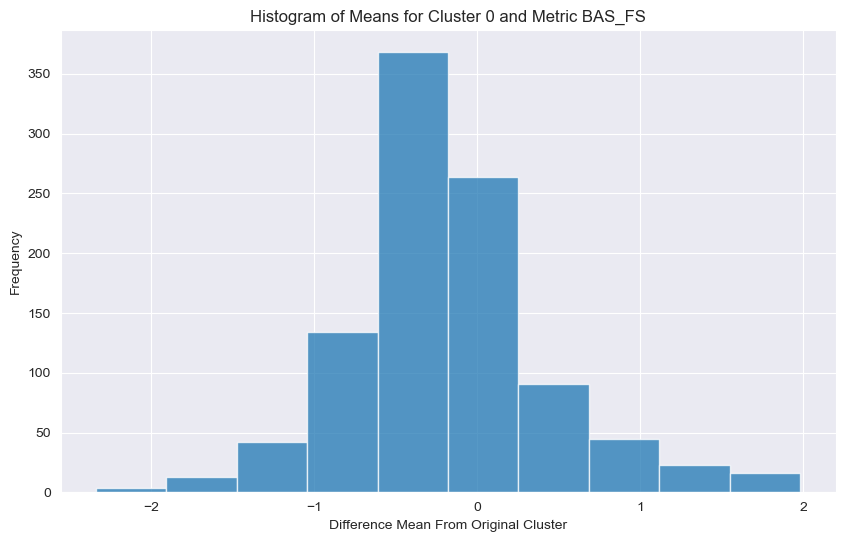

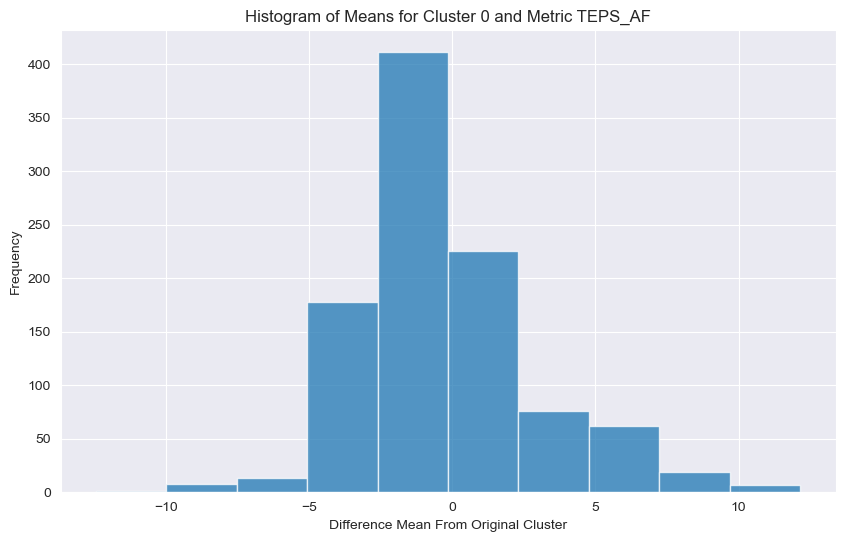

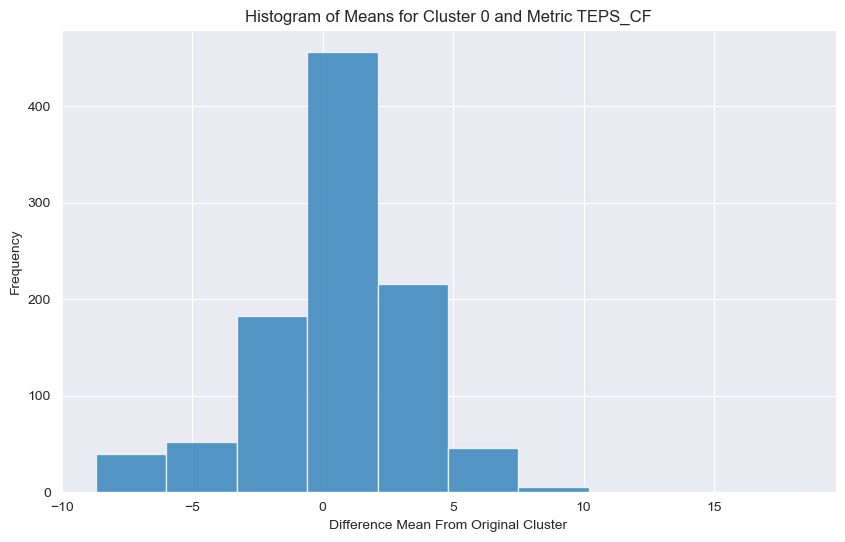

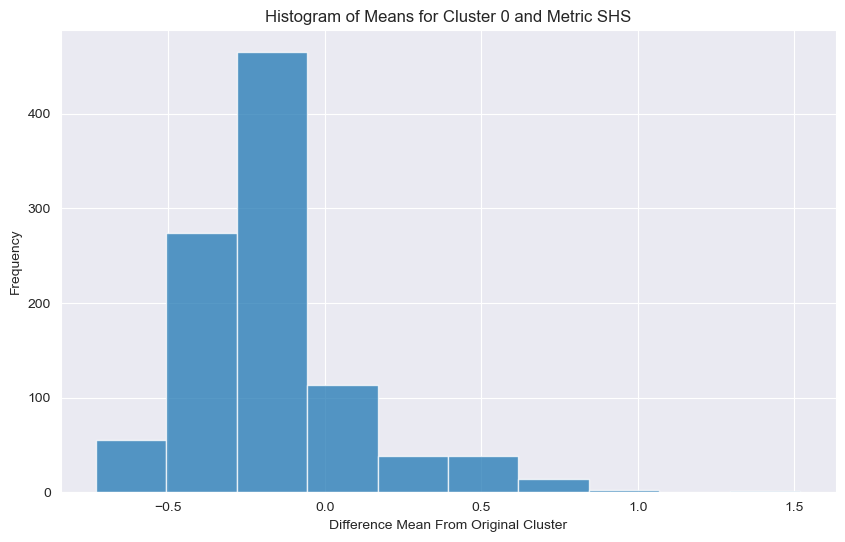

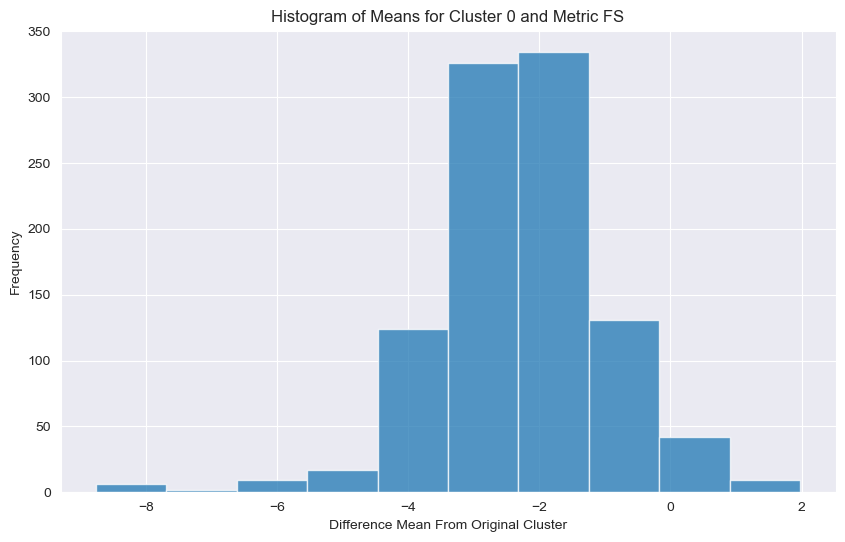

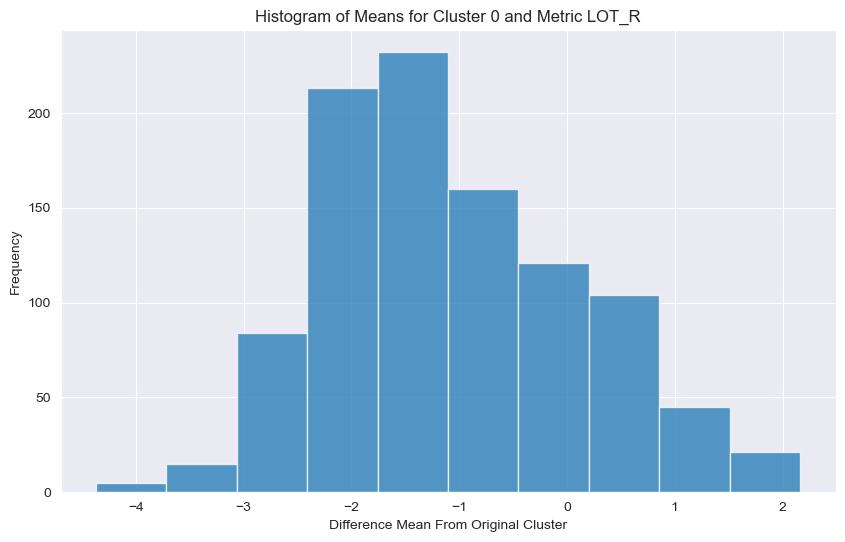

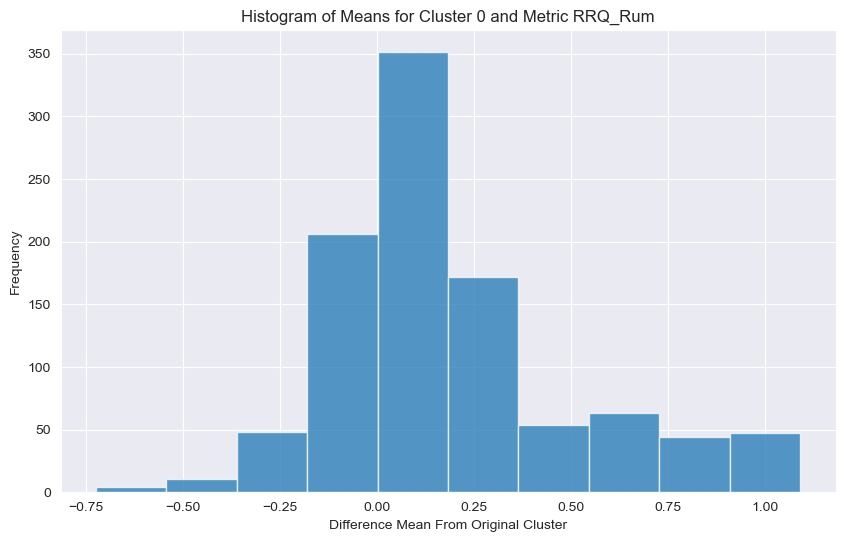

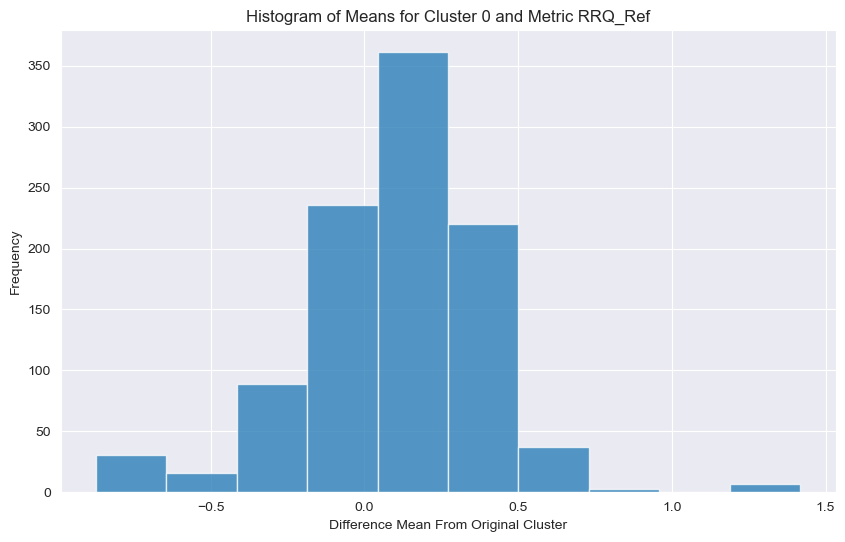

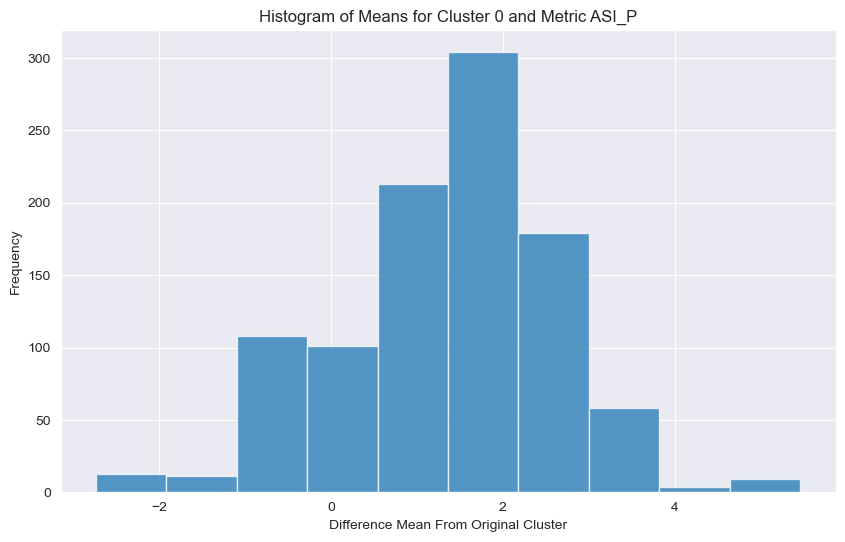

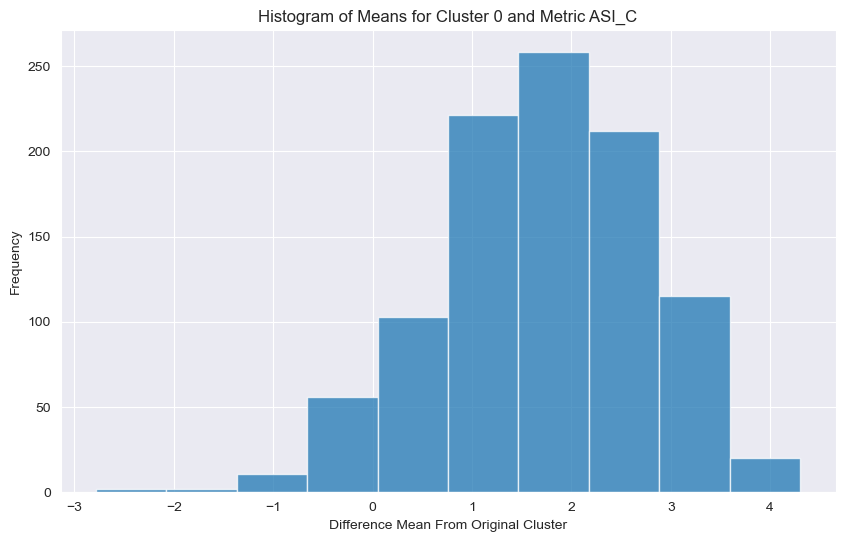

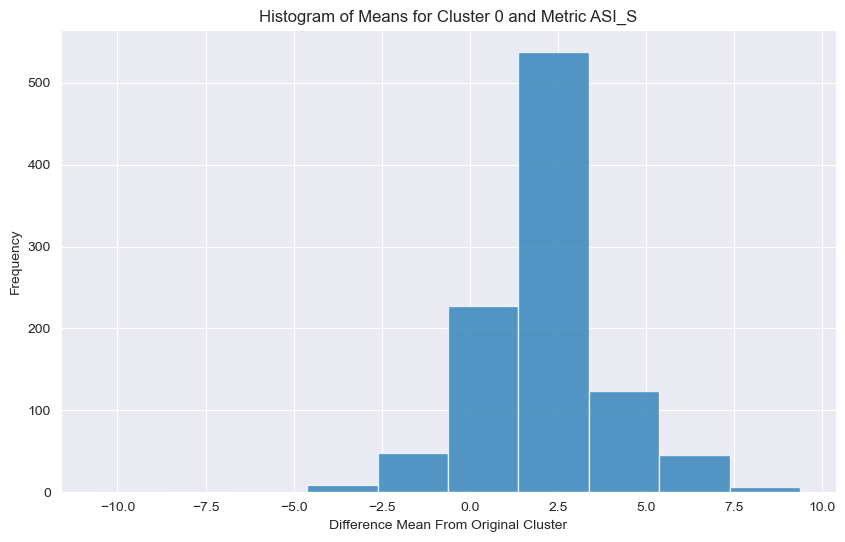

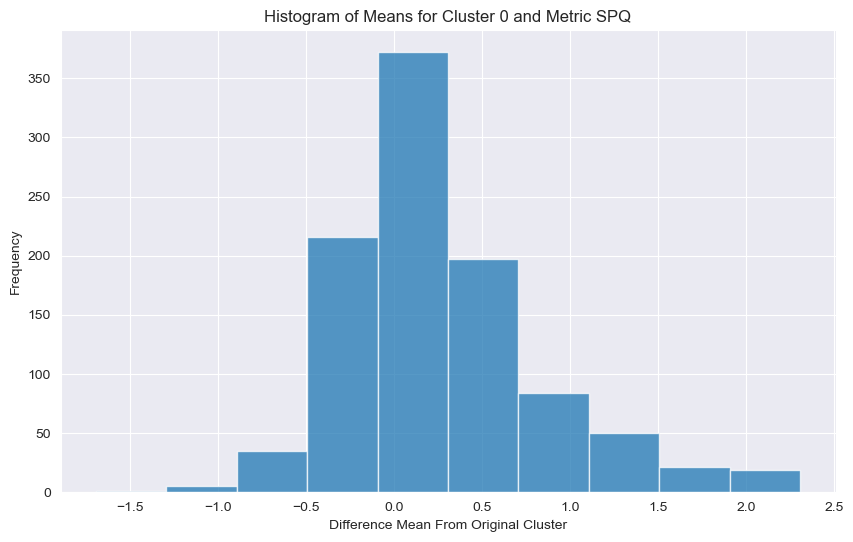

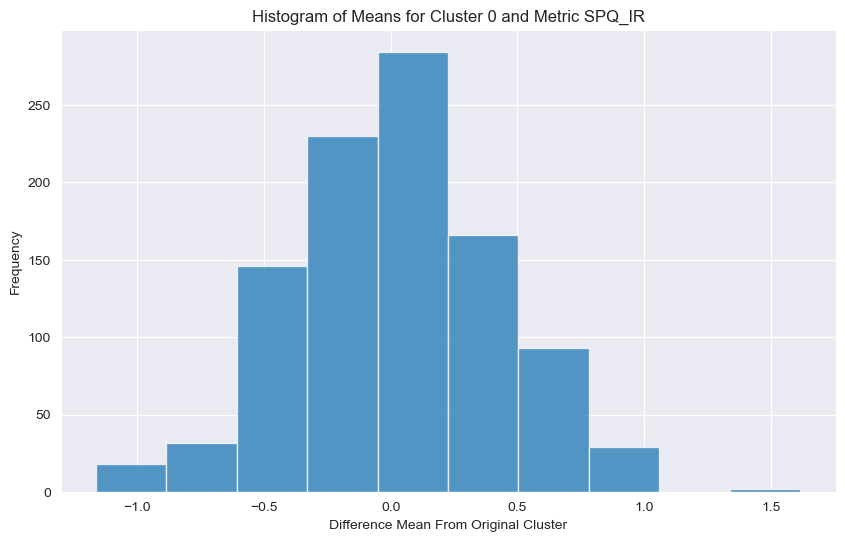

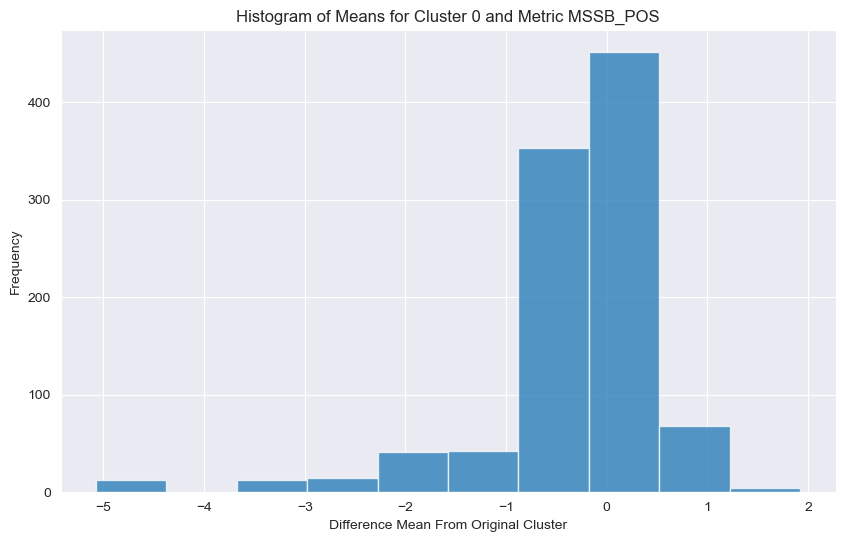

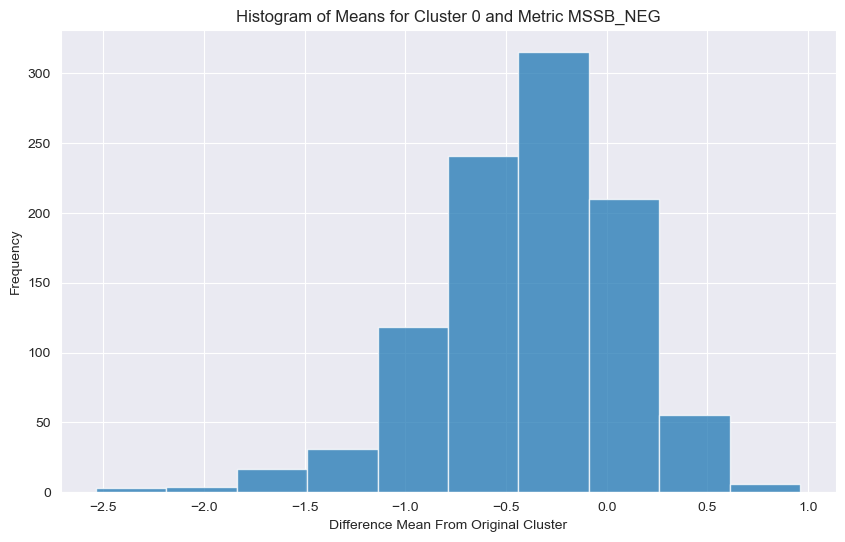

KeyboardInterrupt: 

In [15]:
list_clusters = [0,1,2,3]

predictive_plots.histogram_scales_clusters_bootsrap(means_list,list_clusters)
